In [ ]:
!pip install pybaseball

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 415 kB 5.0 MB/s 
     |████████████████████████████████| 297 kB 60.6 MB/s 
     |████████████████████████████████| 856 kB 15.5 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import torch
import torch.nn as nn 
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pybaseball
import tqdm
from scipy.stats import multivariate_normal as mvnorm 
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### **Data**

In [ ]:
#function to clean and organize data from statcast 
def organize_data(df):

    df = df.loc[df.balls < 4]
    df = df.loc[df.strikes < 3]

    df.dropna(subset = ['release_extension', 
                      'release_speed','release_spin_rate', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z'], axis = 0,
            inplace = True)

    #convert movement to inches instead of feet 
    df[['mx', 'mz']] = df[['pfx_x', 'pfx_z']].values * 12

    #one hot encode handedness
    pit_hand = pd.get_dummies(df['p_throws'], drop_first = False)
    bat_hand = pd.get_dummies(df['stand'], drop_first = False)
    df['pit_handR'] = pit_hand['R']
    df['bat_handR'] = bat_hand['R']
    df = df.drop(['p_throws', 'stand', 'pfx_x', 'pfx_z'], axis = 1)
    
    #remove bunts 
    df = df.loc[df.description.isin(['foul_bunt', 'bunt_foul_tip', 'missed_bunt']) == False]
    df = df.loc[df.events != 'sac_bunt']

    #define the pitch outcome 
    df['outcome'] = -1
    df.loc[df.type == 'B', 'outcome'] = 0 #called ball 
    df.loc[df.description == 'called_strike', 'outcome'] = 1 #called strike 
    df.loc[df.description.isin(['swinging_strike', 'swinging_strike_blocked']), 'outcome'] = 2 #swm 
    df.loc[df.description.isin(['foul', 'foul_tip']), 'outcome'] = 3 #foul ball 

    #the other outcomes are all batted balls, which should either be outs or singles, doubles, triples, or home runs 
    df.loc[(df.type == 'X') & (df.events.isin(['field_out', 'force_out', 'field_error', 'grounded_into_double_play', 'sac_fly', 'fielders_choice', 
                                               'fielders_choice_out', 'double_play', 'other_out', 'triple_play', 
                                               'sac_fly_double_play'])), 'outcome'] = 4 # in play out 
    df.loc[(df.type == 'X') & (df.events == 'single'), 'outcome'] = 5 #single 
    df.loc[(df.type == 'X') & (df.events == 'double'), 'outcome'] = 6 # double 
    df.loc[(df.type == 'X') & (df.events == 'triple'), 'outcome'] = 7 #triple 
    df.loc[(df.type == 'X') & (df.events == 'home_run'), 'outcome'] = 8 #hr 

    #if outcome is still -1, drop it 
    df = df.loc[df.outcome != -1]

    #define an is_swing column 
    df['is_swing'] = -1 
    df.loc[df.description.isin(['hit_into_play', 'foul', 'swinging_strike', 'swinging_strike_blocked', 'foul_tip']), 'is_swing'] = 1
    df.loc[df.description.isin(['called_strike', 'ball', 'blocked_ball', 'hit_by_pitch', 'pitchout']), 'is_swing'] = 0

    #define an is_miss column 
    df['is_miss'] = -1 
    df.loc[df.is_swing == 0 , 'is_miss'] = 0
    df.loc[df.description.isin(['swinging_strike', 'swinging_strike_blocked']), 'is_miss'] = 1 
    df.loc[df.description.isin(['hit_into_play', 'foul', 'foul_tip']), 'is_miss'] = 0
    return df

In [ ]:
#columns needed from statcast 
needed_columns = ['game_date', 'game_year', 'game_pk', 'player_name', 'pitcher', 'batter', 'pitch_type', 'pitch_name', 'stand', 'p_throws', 'balls', 'strikes', 'release_speed', 
                  'release_spin_rate', 'release_extension', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
                  'plate_x', 'plate_z',  'type', 'events', 'description', 'woba_value', 'at_bat_number', 'pitch_number']

In [ ]:
from google.colab import drive
drive.mount('/drive')

#read in the data
raw22 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/raw22.csv')
raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/raw21.csv')
raw19 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/raw18_19_20.csv')
raw21 = raw21[needed_columns]
raw22 = raw22[needed_columns]
raw19 = raw19[needed_columns]

Mounted at /drive


In [ ]:
#clean the data

df21 = organize_data(raw21)
df22 = organize_data(raw22)
#df19 = organize_data(raw19)


all_data = df22.append(df21, ignore_index = True)
#all_data = all_data.append(df19, ignore_index = True)

In [ ]:
#z score variables 
standardizer = StandardScaler().fit(all_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']].values)

all_data[['plate_x_ft', 'plate_z_ft']] = all_data[['plate_x', 'plate_z']].values
all_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']] = standardizer.transform(all_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']].values)

In [ ]:
#get the batter index
batter_indices = pd.DataFrame({'batter': all_data.batter.unique()})

batter_indices['batter_index'] = batter_indices.index.values

#merge 
all_data = all_data.merge(batter_indices, on = 'batter')

In [ ]:
bi = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/batter_indices_final_model.csv')

In [ ]:
testing = bi.merge(batter_indices, how = 'inner', on = 'batter_index')

In [ ]:
#test that all batter indices match with the ones used when the model was trained
testing.shape[0] == bi.shape[0] == batter_indices.shape[0]

True

In [ ]:
features = ['balls', 'strikes', 'release_speed', 'release_spin_rate', 'plate_x', 'plate_z',
                'mx', 'mz', 'pit_handR', 'bat_handR', 'batter_index']

#### **Data Loader**

In [ ]:
train = all_data.copy()

In [ ]:
batch_size = 256

#define a dataloader type thing. Basically we break down at bats by pitch sequence length. 
#then for each length we need to break down all the plate appearances of that length into batches.
pa_lengths = train.groupby(['game_pk', 'at_bat_number'], as_index = False).agg(seq_length = ('pitch_number', 'max'),
                                                                               pitches_recorded = ('pitch_number', 'count'))
#merge with train
train = train.merge(pa_lengths, how = 'inner', on = ['game_pk', 'at_bat_number'])
#make sure the pitches recorded matches the sequence length
train = train.loc[train.seq_length == train.pitches_recorded]

train['pa_id'] = [str(train.game_pk.values[i]) + '-' + str(train.at_bat_number.values[i]) for i in range(train.shape[0])]
#train is ordered from latest to earliest, but I think we want our sequence to go from earliest up top to latest on bottom 
train = train[::-1]

features = ['balls', 'strikes', 'release_speed', 'release_spin_rate', 'plate_x', 'plate_z',
                'mx', 'mz', 'pit_handR', 'bat_handR', 'batter_index']

loader_list = []
for l in pa_lengths.seq_length.unique():
  d = train.loc[train.seq_length == l]
  pas = list(d.pa_id.unique())
  #for each batch, I need to continue to add plate appearances until I hit my batch size 
  while len(pas) > 0:
    pas_for_batch = []
    s = 0 
    while s < batch_size:
      if len(pas) != 0:
        pas_for_batch.append(pas.pop(0))
        s += l
      else:
        s+=1

    #get the pas for this batch 
    batch_data = d.loc[d.pa_id.isin(pas_for_batch)]
    pa_id_and_pitch_num = batch_data[['pa_id', 'pitch_number']].values
    batch_x = batch_data[features].values
    batch_y = batch_data.outcome.values.astype(int)
    #reshape so that each pa is a separate entry in the batch
    batch_x = batch_x.reshape((len(pas_for_batch), l, len(features)))
    batch_y = batch_y.reshape((len(pas_for_batch),l))
    torch_batch_x = torch.tensor(batch_x, dtype = torch.float)
    torch_batch_y = torch.tensor(batch_y, dtype = torch.long)
    
    #append to list 
    loader_list.append((pa_id_and_pitch_num, torch_batch_x, torch_batch_y))


#shuffle the batches so that the RNN is trained on variable length sequences right from the get go 
#this will also give you a train test split 
import random
random.seed(51)
random.shuffle(loader_list)
train_loader_list = loader_list[:3*len(loader_list)//4]
test_loader_list = loader_list[3*len(loader_list)//4:]

#### **Model**

In [ ]:
#helper classes 

batter_embedding_dim = 13
output_embedding_dim = 13

class InputEmbedding(nn.Module):
  def __init__(self, hidden_size = 32, output_size = 9):
    super(InputEmbedding, self).__init__()
    self.hidden_size = hidden_size 
    self.output_size = output_size
    #define batter embedding 
    self.batter_embedding = nn.Embedding(batter_indices.shape[0], embedding_dim = batter_embedding_dim)

    #define embedding for the pitch concatenated with the batter embedding concatenated with hidden state 
    self.ie1 = nn.Linear(in_features = len(features) - 1 + batter_embedding_dim + self.hidden_size, out_features = 512)
    self.ie2 = nn.Linear(512, 256)
    self.ie3 = nn.Linear(256, 128)
    self.ie4 = nn.Linear(128, 64)
    self.ie5 = nn.Linear(64, self.output_size)
    self.relu = nn.ReLU()
    
  def forward(self, x, hidden):
    #batter index is last column of x 
    batter_idx = x[:,-1].int()
    bat_emb = self.batter_embedding(batter_idx)

    #concatenate batter embedding and input and hidden state
    conc = torch.concat((x[:,:-1], bat_emb, hidden), dim = 1)
    
    #run through layers 
    conc = self.relu(self.ie1(conc))
    conc = self.relu(self.ie2(conc))
    conc = self.relu(self.ie3(conc))
    conc = self.relu(self.ie4(conc))
    return self.ie5(conc)


class HiddenStateUpdater(nn.Module):

    def __init__(self, hidden_size = 32, output_size = 9):
        super(HiddenStateUpdater, self).__init__()
        self.hidden_size = hidden_size 
        self.output_size = output_size
        #we need a target embedding 
        self.target_embedding = nn.Embedding(self.output_size, output_embedding_dim)
        #remember, we are going to take our pitch and our output embedding and concatenate them together for the hidden state, so we need features 
        #plus output embedding dim minus 1 for the batter index which we don't want to include.
        self.l1 = nn.Linear(len(features) - 1 + output_embedding_dim, 256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64,32)
        self.proj = nn.Linear(32, self.hidden_size)
        self.relu = nn.ReLU()

    def forward(self, x, y):
        #get the output embedding 
        y = self.target_embedding(y)
        #concatenate onto x 
        x = torch.concat((x, y), dim = -1)
        #feed through network
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x)) 
        x = self.relu(self.l3(x))
        x = self.relu(self.l4(x))
        return self.proj(x)

In [ ]:
class RNN(nn.Module):
  def __init__(self, hidden_size = 32, output_size = 9):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size 
    self.output_size = output_size 

    self.input_embedding = InputEmbedding(self.hidden_size, self.output_size)
    self.h_update = HiddenStateUpdater(self.hidden_size, self.output_size)
    self.relu = nn.ReLU()

    #initialize batter embeddings 
    self.input_embedding.batter_embedding.weight.data.fill_(1.)

  def forward(self, x, hidden, y):
    #first we run x and hidden through the 'input embedding'
    output = self.input_embedding(x, hidden)

    #next, we run x and y through the hidden state updater, and we add that onto the old hidden state
    hidden += self.h_update(x[:,:-1], y)

    #return x and hidden 
    return output, hidden 

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size) 

In [ ]:
model = RNN(hidden_size = 32, output_size = 9).to(device)
model.load_state_dict(torch.load('/drive/My Drive/Colab Notebooks/sequencing_project/final_OP'))

<All keys matched successfully>

#### **Stackelberg Game**

In [ ]:
#define utility function 
count_runs = pd.DataFrame({'balls_pre_event': [3,3,2,3,2,1,0,1,2,0,1,0], 'strikes_pre_event': [0,1,0,2,1,0,0,1,2,1,2,2],
                           'val_ball': [0.131,0.201,0.110,0.276,0.103,0.063,0.034,0.050,0.098,0.027,0.046,0.022],
                           'val_strike': [-0.070,-0.076,-0.062,-0.351,-0.071,-0.050,-0.043,-0.067,-0.252,-0.062,-0.206,-0.184],
                           'val_out': [-0.496,-0.426,-0.385,-0.350,-0.323,-0.323, -0.289,-0.273,-0.252,-0.246,-0.206,-0.184],
                           'val_single': [0.287,0.356,0.397,0.432,0.459,0.460,0.494,0.510,0.530,0.537,0.577,0.598],
                           'val_double': [0.583,0.652,0.693,0.728,0.755,0.756,0.790,0.805,0.826,0.832,0.872,0.894],
                           'val_triple': [0.861,0.930,0.971,1.006,1.033,1.034,1.068,1.083,1.104,1.110,1.150,1.172],
                           'val_hr': [1.2,1.269,1.31,1.345,1.372,1.373,1.407,1.423,1.443,1.45,1.490,1.511]})

def get_utilities(pitch_df):
  '''
  pitch_df is a pandas dataframe with a column for balls, strikes, and the 
  probabilities of each outcome, named o1, o2, o3, o4, o5, o6, o7, and o8

  Returns the expected utility of a swing and of a take for that pitch.
  The batter's optimal utility for the pitch is the larger of those two values
  '''

  pitch_df['swing_utility'] = -1 
  pitch_df['take_utility'] = -1
  pitch_df['actual_run_value'] = np.nan
  for balls in pitch_df.balls.unique():
    for strikes in pitch_df.strikes.unique():
      d = pitch_df.loc[(pitch_df.balls == balls) & (pitch_df.strikes == strikes)]

      #get the corresponding row from count_runs table
      count_pre = count_runs.loc[(count_runs.balls_pre_event == balls) & (count_runs.strikes_pre_event == strikes)]

      #get the value of a called ball 
      val0 = count_pre.val_ball.values[0]

      #get the value of a called or swinging strike 
      val12 = count_pre.val_strike.values[0]

      #value of a foul ball 
      if strikes == 2:
        #no change 
        val3 = 0 
      else:
        #value of foul is just value of a strike
        val3 = count_pre.val_strike.values[0] 

      #value of ball in play out 
      val4 = count_pre.val_out.values[0]
      #single 
      val5 = count_pre.val_single.values[0]
      #double 
      val6 = count_pre.val_double.values[0]
      #triple 
      val7 = count_pre.val_triple.values[0]
      #hr 
      val8 = count_pre.val_hr.values[0]

      #calculate utilities 
      no_swing = d.o0.values + d.o1.values 
      swing = d[['o2','o3','o4','o5','o6','o7','o8']].values.sum(axis = 1)
      take_utility = (d.o0.values / no_swing) * val0 + (d.o1.values/no_swing) * val12
      swing_utility = (d.o2.values/swing) * val12 + (d.o3.values/swing)*val3 + (d.o4.values/swing)*val4 + (d.o5.values/swing)*val5 + (d.o6.values/swing)*val6 + (d.o7.values/swing)*val7 + (d.o8.values/swing) * val8
      d.swing_utility = swing_utility 
      d.take_utility = take_utility  

      #define the actual pitch outcome run value if we have the outcome in the data
      try:
        d.loc[d.outcome == 0, 'actual_run_value'] = val0 
        d.loc[d.outcome.isin([1,2]), 'actual_run_value'] = val12 
        d.loc[d.outcome == 3, 'actual_run_value'] = val3 
        d.loc[d.outcome == 4, 'actual_run_value'] = val4 
        d.loc[d.outcome == 5, 'actual_run_value'] = val5 
        d.loc[d.outcome == 6, 'actual_run_value'] = val6 
        d.loc[d.outcome == 7, 'actual_run_value'] = val7 
        d.loc[d.outcome == 8, 'actual_run_value'] = val8
      except: 
        d.actual_run_value = np.nan

      pitch_df.loc[(pitch_df.strikes == strikes) & (pitch_df.balls == balls), ['swing_utility', 'take_utility', 'actual_run_value']] = d[['swing_utility', 'take_utility', 'actual_run_value']].values

  #recall, in this game the batter observes the full pitch, so we assume he will choose to swing or take based on which one has higher utility, and that will be the ultimate utility of the pitch 
  pitch_df['pitch_utility'] = pitch_df[['swing_utility', 'take_utility']].values.max(axis=1)
  pitch_df['batter_optimal_decision_is_swing'] = pitch_df[['take_utility', 'swing_utility']].values.argmax(axis=1)

  return pitch_df       

In [ ]:
#define the set of pitcher and batters you want to run on 
#Chapman, Anderson, Jansen
pitchers = [547973, 623433, 445276]

#Brosseau, Mookie, Brett Phillips 
batters = [670712, 605141, 621433]

#get the batter indices for the batters 
batter_idxs = [batter_indices.loc[batter_indices.batter == i , 'batter_index'].values[0] for i in batters]

In [ ]:
batter_idxs

[400, 70, 547]

In [ ]:
#get pitch usages and remove the ones less than like 5% 
non_z_scored = all_data.copy()
non_z_scored[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']] = standardizer.inverse_transform(non_z_scored[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']].values)
pitch_usages = pd.DataFrame()
for pitcher in pitchers:
  pdf = non_z_scored.loc[all_data.pitcher == pitcher]
  n = pdf.shape[0]
  usages = pdf.groupby('pitch_type', as_index = False).agg(N = ('is_swing', 'count'),
                                                           release_speed = ('release_speed', 'mean'),
                                                           mx = ('mx', 'mean'),
                                                           mz = ('mz', 'mean'),
                                                           release_spin_rate = ('release_spin_rate', 'mean'))
  usages.N = usages.N / n
  usages['pitcher_id'] = pitcher
  pitch_usages = pitch_usages.append(usages, ignore_index = True)

pitch_usages = pitch_usages.loc[pitch_usages.N >= 0.05]
pitch_usages

,pitch_type,N,release_speed,mx,mz,release_spin_rate,pitcher_id
0,FF,0.561071,97.868091,4.223499,17.960040,2365.819085,547973
1,FS,0.123815,88.202252,2.469189,-1.775135,807.860360,547973
2,SI,0.051311,100.445652,12.790435,15.943043,2406.554348,547973
3,SL,0.263804,85.210994,-11.891163,3.062410,2273.718816,547973
5,CU,0.305785,81.070270,2.033514,-0.149189,1862.648649,623433
6,FF,0.685950,92.920482,-5.083373,18.300723,2112.277108,623433
7,FC,0.606227,92.397356,7.936767,16.901148,2622.221299,445276
8,SI,0.247711,93.759704,-5.858262,19.220850,2292.927911,445276
9,SL,0.146062,81.662382,5.387210,-6.202382,2453.213166,445276


In [ ]:
#define a function that gets the initial grid of utilities, so the grid that will then get uesd to get the execution adjusted grid
#our model requires a hidden state, balls, strikes, and batter and pitch chars to make a prediction. 
#the hidden state will have to be calculated beforehand and plugged in, along with balls, strikes, and handedness.
#this will allow us to just use the output calculation part of OP to make predictions, which will save us time because we won't have to repeatedly update a hidden state 

def initial_grid(batter_idx, pitcherid, h, bhand, phand, balls, strikes):

  #define the grid. I'm adding 3 feet on either side of my normal grid. A baseball is just about 3 inches in diameter, so I'm going to have each point in the grid be half a baseball, so 1.5, so if my dimensions are 9 feet, 
  #I need 9*12/1.5 points in the grid 
  x,z = np.meshgrid(np.linspace(-4.5,4.5,int(9*12/1.5)), np.linspace(-2,7,int(9*12/1.5)))
  x = x.flatten()
  z = z.flatten()
  grid_size = len(x)
  #define the batter and pitcher handedness vecs 
  pvec = np.ones(grid_size) * phand 
  bvec = np.ones(grid_size) * bhand
  #define a location index, so we know how to organize the columns for location
  location_index = np.arange(grid_size)

  #loop through the pitcher's pitches 
  final_data = pd.DataFrame()
  pitcher_usages = pitch_usages.loc[pitch_usages.pitcher_id == pitcherid]
  for pitch in pitcher_usages.pitch_type.unique():
    pitch_chars = pitcher_usages.loc[pitcher_usages.pitch_type == pitch]

    #pitch chars vectors
    svec = np.ones(grid_size) * pitch_chars.release_speed.values[0]
    mxvec = np.ones(grid_size) * pitch_chars.mx.values[0]
    mzvec = np.ones(grid_size) * pitch_chars.mz.values[0]
    srvec = np.ones(grid_size) * pitch_chars.release_spin_rate.values[0]

    #ball and strike vectors 
    balls_v = np.ones(grid_size) * balls 
    strikes_v = np.ones(grid_size) * strikes

    data = pd.DataFrame({'release_speed': svec, 'plate_x' : x, 'plate_z': z,
                             'mx': mxvec, 'mz': mzvec, 'bat_handR': bvec, 
                             'pit_handR': pvec, 'balls': balls_v, 'strikes': strikes_v, 
                             'release_spin_rate': srvec, 'location_index': location_index,
                         'plate_x_ft': x, 'plate_z_ft': z}) 
    
    data['batter_index'] = batter_idx 
    data['pitcher_id'] = pitcherid
    data['pitch_type'] = pitch 
    final_data = final_data.append(data, ignore_index = True)

  #z score variables as needed 
  final_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']] = standardizer.transform(final_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']].values)

  #now we can run the model on final_data, but we need to be able to concatenate on the hidden state 
  #repeate hidden so there is one for every pitch in the data 
  hidden = h.repeat(final_data.shape[0], 1)
  #get the data in a tensor 
  x_data = torch.tensor(final_data[features].values, dtype = torch.float).to(device)
  #run x_data and hidden through the output part of the model 
  preds = nn.functional.softmax(model.input_embedding(x_data, hidden), dim = 1)
  final_data[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = preds.detach().cpu().numpy()

  #get the utilities for final_data
  final_data = get_utilities(final_data)

  return final_data 


In [ ]:
#now use the initial grid and an execution score by pitch type to get the expected utility of a chosen target 
def execution_score_adjusted_grid(init_grid, execution_score_dict):
  #recall init_grid is batter and pitcher specific, so you don't need to worry about having multiple pitchers in init_grid,
  #thus execution_score_dict is a dictionary mapping the execution score to the pitch types for that pitcher 

  #get the location indices corresponding to the smaller grid 
  li = init_grid.loc[(init_grid.plate_x_ft >= -1.5) & (init_grid.plate_x_ft <= 1.5) & (init_grid.plate_z_ft >= 1) & (init_grid.plate_z_ft <= 4), 'location_index'].unique()
  final_data = pd.DataFrame()
  #loop through pitch types 
  for pitch in list(execution_score_dict.keys()):
    d = init_grid.loc[init_grid.pitch_type == pitch]
    #loop through location indices and get the expected utility of swing and take given the pitcher tried to throw the given pitch to the given location index 
    var = execution_score_dict[pitch] ** 2
    for location in li:
      #get the mean for the normal distribution 
      mean = d.loc[d.location_index == location,['plate_x_ft', 'plate_z_ft']].values[0]
      normal = mvnorm(mean, np.eye(2) * var)

      #get likelihoods of all other pitches. 
      d['probability'] = normal.pdf(d[['plate_x_ft', 'plate_z_ft']].values)
      #I'm a little confused on this, but these probabilities don't sum to 1, which I think is just because we're sampling the normal distribution in discrete space and pretending 
      #like that's a good representation of the pdf even though the pdf is continuous, so I need to normalize them. 
      d.probability = d.probability / d.probability.sum()

      #now calculate expected utility for the pitcher given his ability to execute
      exp_util = (d.probability * d.pitch_utility).sum()

      final_data = final_data.append(pd.DataFrame({'pitch_type': pitch, 'location_index': location, 'expected_pitcher_utility': exp_util}, index = [0]))

  return final_data

#### **Brosseau and Chapman**

In [ ]:
#get the at bat from pybaseball, the game was on october 9 2020, and it was the only
#at bat between Chapman and Brosseau, so it should be easy to find in the data 
alds_game_5 = pybaseball.statcast(start_dt = '2020-10-09', end_dt = '2020-10-09')

alds_game_5 = alds_game_5[needed_columns]
alds_game_5 = organize_data(alds_game_5)

This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


In [ ]:
bross_pa = alds_game_5.loc[(alds_game_5.batter == batters[0]) & (alds_game_5.pitcher == pitchers[0])]
bross_pa['batter_index'] = batter_idxs[0]

#run the model on the brosseau pa. Store the hidden state after the second to last pitch, so we can suggest what Chapman should have actually thrown.
bross_pa = bross_pa[::-1]
bross_pa['plate_x_ft'] = bross_pa.plate_x 
bross_pa['plate_z_ft'] = bross_pa.plate_z 
bross_pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']] = standardizer.transform(bross_pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']].values)

#loop through the pitches
pred_outcomes = torch.empty((1,9)).to(device)
x_data = torch.tensor(bross_pa[features].values.astype(float), dtype = torch.float).to(device)
y_data = torch.tensor(bross_pa.outcome.values, dtype = torch.long).to(device)
h0 = model.init_hidden().to(device)
for p in range(bross_pa.shape[0]):
  yhat, h1 = model(x_data[p].unsqueeze(0), h0, y_data[p].unsqueeze(0))
  pred_outcomes = torch.cat((pred_outcomes, yhat), dim = 0)
  h0 = h1 
  if p == bross_pa.shape[0] - 2:
    #save the hidden state after the second to last pitch 
    h = h0 

#now softmax the predictions and append onto the bross pa 
ypreds = nn.functional.softmax(pred_outcomes[1:,:], dim = 1).detach().cpu().numpy()
bross_pa[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = ypreds 

#and calculate the utilities for each of those pitches 
bross_pa = get_utilities(bross_pa)

#now we can see the utilities of all of those pitches, and most interestingly the utility of the last pitch
bross_pa.tail(1)[['player_name', 'batter', 'pitch_type', 'balls', 'strikes','plate_x', 'plate_z', 'plate_x_ft', 'plate_z_ft', 'outcome', 'o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'swing_utility', 'take_utility', 'pitch_utility', 'batter_optimal_decision_is_swing']]

,player_name,batter,pitch_type,balls,strikes,plate_x,plate_z,plate_x_ft,plate_z_ft,outcome,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility,pitch_utility,batter_optimal_decision_is_swing
168,"Chapman, Aroldis",670712,FF,3,2,-0.690644,-0.165659,-0.54,2.12,8,0.002091,0.084918,0.111242,0.476575,0.215287,0.069385,0.022547,0.001767,0.016188,-0.048694,-0.335929,-0.048694,1


In [ ]:
#we calculated the hidden state after the 9th pitch, so the pitch right before that last pitch, in the previous cell, so we can use that to get the utilities for all of Chapman's pitches 
#given the prior sequence
igrid = initial_grid(batter_idxs[0], pitchers[0], h, 1., 0., balls = 3, strikes = 2)

#get the execution score adjusted grid 
exe_grid = execution_score_adjusted_grid(igrid, {'FF': 0.753, 'FS': 0.921, 'SI': 0.719, 'SL': 0.657})

In [ ]:
final_data = igrid.merge(exe_grid, how = 'inner', on = ['pitch_type', 'location_index'])

It's interesting, the pitcher decision should be the one with the minimum expected utility considering his execution score, but the best pitch he could possibly throw is the one with the minimum pitch utility in the dataframe, so compare those.

In [ ]:
actual_min = final_data.pitch_utility.min()
expected_min = final_data.expected_pitcher_utility.min()
best_possible_pitch = final_data.loc[final_data.pitch_utility == actual_min]
pitcher_optimal_decision = final_data.loc[final_data.expected_pitcher_utility == expected_min]

In [ ]:
best_possible_pitch

,release_speed,plate_x,plate_z,mx,mz,bat_handR,pit_handR,balls,strikes,release_spin_rate,location_index,plate_x_ft,plate_z_ft,batter_index,pitcher_id,pitch_type,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility,actual_run_value,pitch_utility,batter_optimal_decision_is_swing,expected_pitcher_utility
687,-0.111033,0.474967,-0.749311,0.362225,-1.055385,1.0,0.0,3.0,2.0,-4.28622,2055,0.443662,1.549296,400,547973,FS,0.010379,0.024404,0.32517,0.330999,0.229306,0.057502,0.014377,0.00083,0.007032,-0.154153,-0.163908,NaN,-0.154153,1,0.145516


In [ ]:
pitcher_optimal_decision

,release_speed,plate_x,plate_z,mx,mz,bat_handR,pit_handR,balls,strikes,release_spin_rate,location_index,plate_x_ft,plate_z_ft,batter_index,pitcher_id,pitch_type,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility,actual_run_value,pitch_utility,batter_optimal_decision_is_swing,expected_pitcher_utility
2005,-0.601416,0.174552,0.158143,-1.002816,-0.515481,1.0,0.0,3.0,2.0,0.098252,2557,0.190141,2.43662,400,547973,SL,0.000205,0.054932,0.137899,0.375847,0.285135,0.077049,0.03326,0.002724,0.03295,-0.046191,-0.348668,NaN,-0.046191,1,0.007187


The pitch that Chapman actually threw was a fastball. The right decision for Brosseau on that pitch was to swing, which gave an expected run value of -0.05. Brosseau did make that decision, but unfortunately for Chapman, and fortunately for Rays fans and really for the whole world, Brosseau greatly outperformed the expected run value and hit a home run. The best possible pitch that Chapman could have thrown, ignoring his ability to execute, was a splitter a little bit outside and down in the strike zone. That gave an expected take utility of -0.16, and an expected swing utility of -0.15, so Brosseau would want to swing at that pitch, but it would likely not have worked out well for him. The actual equilibrium pitch that Chapman should have thrown, so the pitch that minimizes expected run value considering Chapman's ability to execute, was a slider basically middle middle. That gives a swing utility of -0.05, a take utility of -0.35, and an expected pitch utility over execution score of 0.007. Interestingly, when we factor in execution score, there was no pitch that Chapman could throw with a negative run value, which is I guess a function of him maybe not having a great execution ability. 

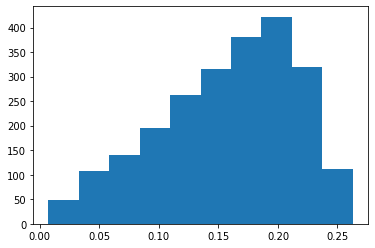

In [ ]:
#all of chapman's expected utilities. None of them are negative!
plt.hist(final_data.expected_pitcher_utility.values)
plt.show()

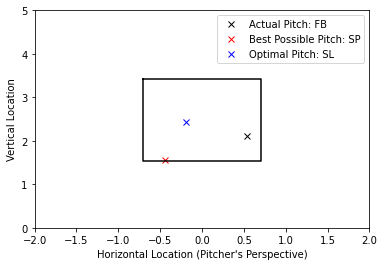

In [ ]:
#plot the actual pitch, the absolute best pitch, and the optimal equilibrium pitch 
plt.plot(-1*bross_pa.plate_x_ft.values[-1], bross_pa.plate_z_ft.values[-1], 'kx', label = 'Actual Pitch: FB')
plt.plot(-1*best_possible_pitch.plate_x_ft.values[0], best_possible_pitch.plate_z_ft.values[0], 'rx', label = 'Best Possible Pitch: SP')
plt.plot(-1*pitcher_optimal_decision.plate_x_ft.values[0], pitcher_optimal_decision.plate_z_ft.values[0], 'bx', label = 'Optimal Pitch: SL')
plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
plt.legend()
plt.xlabel("Horizontal Location (Pitcher's Perspective)")
plt.ylabel('Vertical Location')
plt.xlim(-2.,2.)
plt.ylim(0,5)
plt.show()

#### **Anderson vs Mookie**

In [ ]:
#get the at bat from pybaseball
game = pybaseball.statcast(start_dt = '2020-10-27', end_dt = '2020-10-27')

game = game[needed_columns]
game = organize_data(game)

This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:05<00:00,  5.28s/it]


In [ ]:
pa = game.loc[(game.batter == batters[1]) & (game.pitcher == pitchers[1])]
pa['batter_index'] = batter_idxs[1]

#run the model on the brosseau pa. Store the hidden state after the second to last pitch, so we can suggest what Chapman should have actually thrown.
pa = pa[::-1]
pa['plate_x_ft'] = pa.plate_x 
pa['plate_z_ft'] = pa.plate_z 
pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']] = standardizer.transform(pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']].values)

#loop through the pitches
pred_outcomes = torch.empty((1,9)).to(device)
x_data = torch.tensor(pa[features].values.astype(float), dtype = torch.float).to(device)
y_data = torch.tensor(pa.outcome.values, dtype = torch.long).to(device)
h0 = model.init_hidden().to(device)
for p in range(pa.shape[0]):
  yhat, h1 = model(x_data[p].unsqueeze(0), h0, y_data[p].unsqueeze(0))
  pred_outcomes = torch.cat((pred_outcomes, yhat), dim = 0)
  h0 = h1 
  if p == pa.shape[0] - 2:
    #save the hidden state after the second to last pitch 
    h = h0 

#now softmax the predictions and append onto the bross pa 
ypreds = nn.functional.softmax(pred_outcomes[1:,:], dim = 1).detach().cpu().numpy()
pa[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = ypreds 

#and calculate the utilities for each of those pitches 
pa = get_utilities(pa)

#now we can see the utilities of all of those pitches, and most interestingly the utility of the last pitch
pa[['player_name', 'batter', 'pitch_type', 'balls', 'strikes','plate_x', 'plate_z', 'plate_x_ft', 'plate_z_ft', 'outcome', 'o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'swing_utility', 'take_utility', 'pitch_utility', 'batter_optimal_decision_is_swing']]

,player_name,batter,pitch_type,balls,strikes,plate_x,plate_z,plate_x_ft,plate_z_ft,outcome,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility,pitch_utility,batter_optimal_decision_is_swing
253,"Anderson, Nick",605141,FF,0,0,1.442304,0.928616,1.26,3.19,0,0.977774,0.002205,0.008487,0.008363,0.002272,0.000748,0.000118,0.000005,0.000027,-0.043662,0.033827,0.033827,0
242,"Anderson, Nick",605141,FF,1,0,1.596351,0.539995,1.39,2.81,0,0.962326,0.000915,0.017599,0.014193,0.003655,0.001091,0.000174,0.000007,0.000040,-0.056432,0.062893,0.062893,0
231,"Anderson, Nick",605141,FF,2,0,0.375830,0.539995,0.36,2.81,6,0.000797,0.293805,0.165113,0.337587,0.131421,0.035943,0.015856,0.001682,0.017796,-0.044742,-0.061535,-0.044742,1


In [ ]:
#we calculated the hidden state after the 2nd pitch, so the pitch right before that last pitch, in the previous cell, so we can use that to get the utilities for all of Anderson's
#given the prior sequence
igrid = initial_grid(batter_idxs[1], pitchers[1], h, bhand = 1., phand = 1., balls = 2, strikes = 0)

#get the execution score adjusted grid 
exe_grid = execution_score_adjusted_grid(igrid, {'CU': 0.604, 'FF': 0.521})

In [ ]:
final_data = igrid.merge(exe_grid, how = 'inner', on = ['pitch_type', 'location_index'])

In [ ]:
actual_min = final_data.pitch_utility.min()
expected_min = final_data.expected_pitcher_utility.min()
best_possible_pitch = final_data.loc[final_data.pitch_utility == actual_min]
pitcher_optimal_decision = final_data.loc[final_data.expected_pitcher_utility == expected_min]

In [ ]:
best_possible_pitch

,release_speed,plate_x,plate_z,mx,mz,bat_handR,pit_handR,balls,strikes,release_spin_rate,location_index,plate_x_ft,plate_z_ft,batter_index,pitcher_id,pitch_type,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility,actual_run_value,pitch_utility,batter_optimal_decision_is_swing,expected_pitcher_utility
280,-1.280241,0.625175,0.158143,0.320812,-0.873918,1.0,1.0,2.0,0.0,-1.131284,2560,0.570423,2.43662,70,623433,CU,0.001567,0.748361,0.037181,0.084954,0.087408,0.024648,0.008021,0.000834,0.007025,-0.063455,-0.061641,NaN,-0.061641,0,-0.00016


In [ ]:
pitcher_optimal_decision

,release_speed,plate_x,plate_z,mx,mz,bat_handR,pit_handR,balls,strikes,release_spin_rate,location_index,plate_x_ft,plate_z_ft,batter_index,pitcher_id,pitch_type,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility,actual_run_value,pitch_utility,batter_optimal_decision_is_swing,expected_pitcher_utility
852,0.662468,0.024344,0.158143,-0.355693,1.185223,1.0,1.0,2.0,0.0,-0.38463,2556,0.06338,2.43662,70,623433,FF,0.000199,0.223998,0.096256,0.352111,0.205041,0.059424,0.028231,0.00272,0.032019,-0.024488,-0.061847,NaN,-0.024488,1,-0.015141


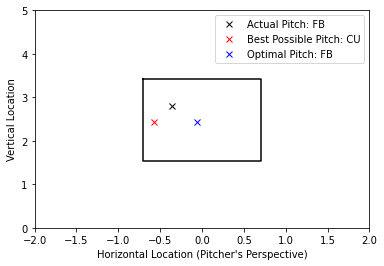

In [ ]:
#plot the actual pitch, the absolute best pitch, and the optimal equilibrium pitch 
plt.plot(-1*pa.plate_x_ft.values[-1], pa.plate_z_ft.values[-1], 'kx', label = 'Actual Pitch: FB')
plt.plot(-1*best_possible_pitch.plate_x_ft.values[0], best_possible_pitch.plate_z_ft.values[0], 'rx', label = 'Best Possible Pitch: CU')
plt.plot(-1*pitcher_optimal_decision.plate_x_ft.values[0], pitcher_optimal_decision.plate_z_ft.values[0], 'bx', label = 'Optimal Pitch: FB')
plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
plt.legend()
plt.xlabel("Horizontal Location (Pitcher's Perspective)")
plt.ylabel('Vertical Location')
plt.xlim(-2.,2.)
plt.ylim(0,5)
plt.show()

In [ ]:
np.linalg.norm((pa[['plate_x_ft', 'plate_z_ft']].values[-1] - pitcher_optimal_decision[['plate_x_ft', 'plate_z_ft']].values[0]))

0.4768606631346616

The optimal pitch for Anderson in the stackelberg game is actually the same pitch we got in the Nash game, a fastball down the middle. In the Nash game though, Mookie happens to have a pure take strategy, so the expected utility is a little lower than in this game, where we actually expect Mookie to swing at that pitch. The best possible pitch is a curveball on the outside edge of the strike zone, but I guess we wouldn't actually throw that pitch because Anderson is likely to miss the plate for a ball. That's really interesting that the optimal pitch in this game is the same as the one in the nash game. I guess when you factor in execution scores, all the pitches around this fastball are probably still pretty good, so it would be a good pitch to throw. Also, the actual pitch that Anderson threw is within 1 fastball execution score standard deviation of this pitch, so it is possible that Anderson actually was using this strategy for this pitch. Overall, the model doesn't think that the pitch Anderson threw was that bad, and it actually recommends a similar pitch. Perhaps Mookie just beat him or got a little lucky.

#### **Jansen vs Phillips**

In [ ]:
#get the at bat from pybaseball
game = pybaseball.statcast(start_dt = '2020-10-24', end_dt = '2020-10-24')

game = game[needed_columns]
game = organize_data(game)

This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


In [ ]:
pa = game.loc[(game.batter == batters[2]) & (game.pitcher == pitchers[2])]
pa['batter_index'] = batter_idxs[2]

#run the model on the pa
pa = pa[::-1]
pa['plate_x_ft'] = pa.plate_x 
pa['plate_z_ft'] = pa.plate_z 
pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']] = standardizer.transform(pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']].values)
#loop through the pitches
pred_outcomes = torch.empty((1,9)).to(device)
x_data = torch.tensor(pa[features].values.astype(float), dtype = torch.float).to(device)
y_data = torch.tensor(pa.outcome.values, dtype = torch.long).to(device)
h0 = model.init_hidden().to(device)
for p in range(pa.shape[0]):
  yhat, h1 = model(x_data[p].unsqueeze(0), h0, y_data[p].unsqueeze(0))
  pred_outcomes = torch.cat((pred_outcomes, yhat), dim = 0)
  h0 = h1 
  if p == pa.shape[0] - 2:
    #save the hidden state after the second to last pitch 
    h = h0 

#now softmax the predictions and append onto the bross pa 
ypreds = nn.functional.softmax(pred_outcomes[1:,:], dim = 1).detach().cpu().numpy()
pa[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = ypreds 

#and calculate the utilities for each of those pitches 
pa = get_utilities(pa)

pa[['player_name', 'batter', 'pitch_type', 'balls', 'strikes','plate_x', 'plate_z', 'plate_x_ft', 'plate_z_ft', 'outcome', 'o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'swing_utility', 'take_utility', 'pitch_utility', 'batter_optimal_decision_is_swing']]

,player_name,batter,pitch_type,balls,strikes,plate_x,plate_z,plate_x_ft,plate_z_ft,outcome,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility,pitch_utility,batter_optimal_decision_is_swing
141,"Jansen, Kenley",621433,FC,0,0,1.146061,-0.073618,1.01,2.21,0,0.359006,0.031942,0.126646,0.338238,0.106224,0.027180,0.007599,0.000437,0.002729,-0.044253,0.027709,0.027709,0
135,"Jansen, Kenley",621433,FC,1,0,0.980166,0.785439,0.87,3.05,1,0.338521,0.105583,0.069858,0.310959,0.130165,0.030707,0.009224,0.000622,0.004362,-0.060000,0.036135,0.036135,0
130,"Jansen, Kenley",621433,SI,1,1,-1.046135,-0.462239,-0.84,1.83,1,0.414153,0.459284,0.022835,0.056786,0.031509,0.010899,0.003123,0.000260,0.001151,-0.031176,-0.011523,-0.011523,0
121,"Jansen, Kenley",621433,FC,1,2,0.494327,0.130920,0.46,2.41,5,0.000996,0.026303,0.060885,0.420487,0.337110,0.101409,0.029200,0.002181,0.021429,0.037448,-0.196806,0.037448,1


In [ ]:
#we calculated the hidden state after the 2nd pitch, so the pitch right before that last pitch, in the previous cell, so we can use that to get the utilities for all of Anderson's
#given the prior sequence
igrid = initial_grid(batter_idxs[2], pitchers[2], h, bhand = 0., phand = 1., balls = 1, strikes = 2)

#get the execution score adjusted grid 
exe_grid = execution_score_adjusted_grid(igrid, {'FC': 0.51, 'SI':0.61, 'SL': 0.636})

In [ ]:
final_data = igrid.merge(exe_grid, how = 'inner', on = ['pitch_type', 'location_index'])

In [ ]:
actual_min = final_data.pitch_utility.min()
expected_min = final_data.expected_pitcher_utility.min()
best_possible_pitch = final_data.loc[final_data.pitch_utility == actual_min]
pitcher_optimal_decision = final_data.loc[final_data.expected_pitcher_utility == expected_min]

In [ ]:
best_possible_pitch

,release_speed,plate_x,plate_z,mx,mz,bat_handR,pit_handR,balls,strikes,release_spin_rate,location_index,plate_x_ft,plate_z_ft,batter_index,pitcher_id,pitch_type,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility,actual_run_value,pitch_utility,batter_optimal_decision_is_swing,expected_pitcher_utility
415,0.576707,-0.726694,0.935962,0.881953,1.02902,0.0,1.0,1.0,2.0,1.140644,2983,-0.570423,3.197183,547,445276,FC,0.273132,0.272579,0.182156,0.202072,0.049131,0.011968,0.004932,0.0004,0.003628,-0.067297,-0.079872,NaN,-0.067297,1,0.012858


In [ ]:
pitcher_optimal_decision

,release_speed,plate_x,plate_z,mx,mz,bat_handR,pit_handR,balls,strikes,release_spin_rate,location_index,plate_x_ft,plate_z_ft,batter_index,pitcher_id,pitch_type,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility,actual_run_value,pitch_utility,batter_optimal_decision_is_swing,expected_pitcher_utility
369,0.576707,-0.426278,0.676689,0.881953,1.02902,0.0,1.0,1.0,2.0,1.140644,2841,-0.316901,2.943662,547,445276,FC,0.00766,0.197531,0.213451,0.402459,0.120789,0.031257,0.013161,0.001296,0.012395,-0.024387,-0.196592,NaN,-0.024387,1,0.006701


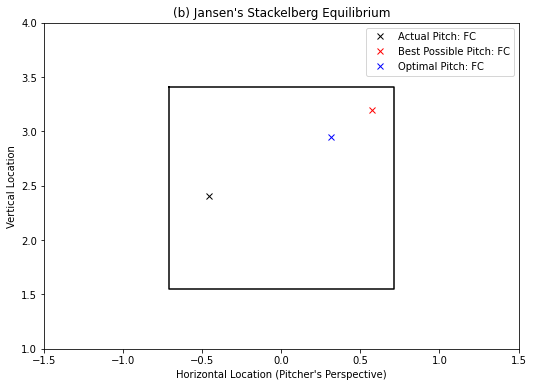

In [ ]:
#plot the actual pitch, the absolute best pitch, and the optimal equilibrium pitch 
plt.figure(figsize = (8.5,6))
plt.plot(-1*pa.plate_x_ft.values[-1], pa.plate_z_ft.values[-1], 'kx', label = 'Actual Pitch: FC')
plt.plot(-1*best_possible_pitch.plate_x_ft.values[0], best_possible_pitch.plate_z_ft.values[0], 'rx', label = 'Best Possible Pitch: FC')
plt.plot(-1*pitcher_optimal_decision.plate_x_ft.values[0], pitcher_optimal_decision.plate_z_ft.values[0], 'bx', label = 'Optimal Pitch: FC')
plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
plt.legend()
plt.xlabel("Horizontal Location (Pitcher's Perspective)")
plt.ylabel('Vertical Location')
plt.xlim(-1.5,1.5)
plt.ylim(1,4)
plt.title("(b) Jansen's Stackelberg Equilibrium")
plt.show()

This is pretty cool, the best possible pitch, optimal pitch, and actual pitch were all cutters. Jansen did not throw the ball anywhere close to where he should of according to this game. The swing utility on the pitch he threw was 0.037, so good for Phillips. The swing utility on the best possible pitch was -0.067, and it was -0.024 on the optimal pitch. The expected utility for those two pitches, factoring execution score, is 0.013 and 0.007 respectively, so both better than the utility on the actual pitch he threw. It is technically possible that Jansen was actually aiming at that blue x, and he just missed really badly and it cost him. So yeah really cool!

#### **Testing Optimality of Batter Decisions**

In this section, we are going to run the model on every pitch in the validation set. Then we are going to calculate the swing and take utility and define the optimal decision for each batter in the validation set. Then we will see how frequently batters make the optimal decision.

In [ ]:
def prediction_func(input, target, recurrent = True):
  #input is a batch of PAs 
  with torch.no_grad():
    #init 
    input = input.to(device)
    target = target.to(device)
    loss = 0

    input_length = input.size(1)

    #loop through pas in batch 
    preds = torch.empty((1,9)).to(device)
    for pa_num in range(input.size(0)):
      #initialize hidden state at start of each pa 
      h0 = model.init_hidden()
      h0 = h0.to(device)
      pa = input[pa_num]
      pa_targets = target[pa_num]
      for pitch in range(input_length):
        yhat, h1 = model(pa[pitch].unsqueeze(0), h0, pa_targets[pitch].unsqueeze(0))
        preds = torch.cat((preds, yhat), dim = 0)
        if recurrent:
          h0 = h1
        else:
          h0 = model.init_hidden().to(device)

    #return predictions
    return preds[1:,:]

In [ ]:
#get the predictions
predicted_test_data = pd.DataFrame()
for batch in range(len(test_loader_list)):
  ids, x, y = test_loader_list[batch]
  
  ypred = prediction_func(x,y)

  y = y.view(y.size(0)*y.size(1))
  losses = nn.CrossEntropyLoss(reduction = 'none')(ypred, y.cuda())
  new_data = pd.DataFrame({'pa_id': ids[:,0], 'pitch_number': ids[:,1], 'outcome': y.cpu().numpy()})
  new_data[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = nn.functional.softmax(ypred, dim = 1).detach().cpu().numpy()
  new_data['cross_entropy_loss'] = losses.detach().cpu().numpy()
  predicted_test_data = predicted_test_data.append(new_data, ignore_index = True)

In [ ]:
#inner join train and predicted_test_data to get other needed info
test = train.merge(predicted_test_data[['pa_id', 'pitch_number', 'o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']], how = 'inner', on = ['pa_id', 'pitch_number'])

#calculate the necessary utilities for test 
test = get_utilities(test)

#define a bool that is true if the batter made the right swing decision 
test['correct_batter_decision_bool'] = (np.abs(test.is_swing - test.batter_optimal_decision_is_swing) == 0)

In [ ]:
test.correct_batter_decision_bool.mean()

0.7017616381729335

Batter makes the correct decision about 70\% of the time, which coincidentally matches the correct decision rate that the smaller subset of batters made in the decision point game.

In [ ]:
#see which batters are making the best decisions most often 
batter_results = test.groupby('batter', as_index = False).agg(n = ('is_swing', 'count'), 
                                             correct_decision_rate = ('correct_batter_decision_bool', 'mean'),
                                             swing_rate = ('is_swing', 'mean'),
                                             miss_rate = ('is_miss', 'mean'),
                                             optimal_decision_is_swing_rate = ('batter_optimal_decision_is_swing', 'mean'),
                                             avg_optimal_utility = ('pitch_utility', 'mean'),
                                             avg_run_value_actual_outcomes = ('actual_run_value', 'mean'))
#remove batter's with few pitches 
batter_results = batter_results.loc[batter_results.n > 50]

In [ ]:
batter_results.sort_values(by = 'correct_decision_rate', ascending = False)

,batter,n,correct_decision_rate,swing_rate,miss_rate,optimal_decision_is_swing_rate,avg_optimal_utility,avg_run_value_actual_outcomes
258,592261,64,0.859375,0.343750,0.078125,0.328125,0.023789,0.010859
832,664068,52,0.846154,0.519231,0.173077,0.519231,0.013972,-0.007481
254,592200,117,0.837607,0.666667,0.094017,0.589744,0.020823,0.003744
1136,677954,60,0.833333,0.400000,0.050000,0.333333,0.022196,0.002033
1060,672478,52,0.826923,0.692308,0.134615,0.596154,0.004674,0.036712
...,...,...,...,...,...,...,...,...
448,609280,57,0.491228,0.578947,0.192982,0.456140,0.004920,-0.041421
1184,681481,51,0.470588,0.529412,0.196078,0.549020,0.006761,-0.008667
244,573186,79,0.468354,0.531646,0.265823,0.582278,0.007829,-0.064241
201,554430,119,0.453782,0.478992,0.268908,0.521008,0.005349,-0.040630


Top 5 are Delino Deshields, Scott Kingery, Curt Casali!!, Jordan Groshans, Jordan Diaz. Bottom 5 are Diego Castillo (not the pitcher), two pitchers I skipped (wheeler and stroman), Kerry Carpenter, Miguel Andujar. 

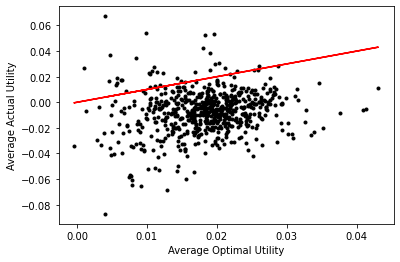

In [ ]:
#plot the average optimal utility with the actual average run values. This will show if making optimal decisions in this game is related with actually having good outcomes for the batter
plt.plot(batter_results.avg_optimal_utility.values, batter_results.avg_run_value_actual_outcomes.values, 'k.')
plt.plot(batter_results.avg_optimal_utility.values, batter_results.avg_optimal_utility.values, 'r-')
plt.xlabel('Average Optimal Utility')
plt.ylabel('Average Actual Utility')
plt.show()

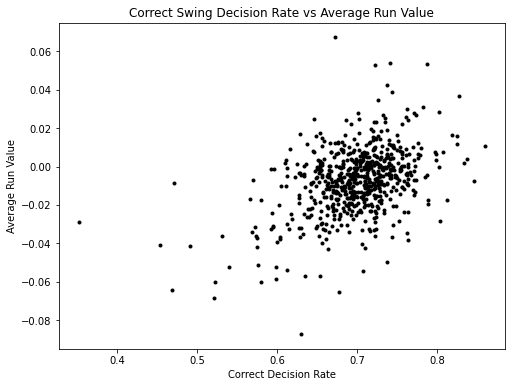

Correlation: 0.42779207065403146


In [ ]:
#plot the actual utility compared to the percentage of correct decisions
plt.figure(figsize = (8,6))
plt.plot(batter_results.correct_decision_rate.values, batter_results.avg_run_value_actual_outcomes.values, 'k.')
plt.xlabel('Correct Decision Rate')
plt.ylabel('Average Run Value')
plt.title('Correct Swing Decision Rate vs Average Run Value')
plt.show()
print('Correlation: ' +  str(np.corrcoef(batter_results.correct_decision_rate.values, batter_results.avg_run_value_actual_outcomes.values)[0,1]))

#### **Testing pitchers**

In [ ]:
#read in the skill estimates 
skill = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/pitcher_skill_estimates.csv')

skill.columns = ['pitcher', 'pitcher_name', 'avg', 'CH', 'CU', 'FC', 'FF', 'FS', 'KC', 'SI', 'SL']

In [ ]:
#get the usages for each of these pitchers 
non_z_scored = all_data.copy()
non_z_scored[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']] = standardizer.inverse_transform(non_z_scored[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']].values)
pitch_usages = pd.DataFrame()
for pitcher in skill.pitcher.values:
  pdf = non_z_scored.loc[all_data.pitcher == pitcher]
  n = pdf.shape[0]
  usages = pdf.groupby('pitch_type', as_index = False).agg(N = ('is_swing', 'count'),
                                                           release_speed = ('release_speed', 'mean'),
                                                           mx = ('mx', 'mean'),
                                                           mz = ('mz', 'mean'),
                                                           release_spin_rate = ('release_spin_rate', 'mean'))
  usages.N = usages.N / n
  usages['pitcher_id'] = pitcher
  pitch_usages = pitch_usages.append(usages, ignore_index = True)

pitch_usages = pitch_usages.loc[pitch_usages.N >= 0.05]

In [ ]:
#define a dictionary of execution score dictionaries for each pitcher 
execution_scores = dict()
for pitcher in skill.pitcher.values:
  pitches = pitch_usages.loc[pitch_usages.pitcher_id == pitcher]
  pitcher_skill = skill.loc[skill.pitcher == pitcher]
  pitch_dict = dict()
  for p in pitches.pitch_type.values:
    pitch_dict.update({p: pitcher_skill[[p]].values[0]})
  
  execution_scores.update({pitcher: pitch_dict})

In [ ]:
#we need the batters we're going to test on. Identify the top 3 most faced batters in the data for each pitcher
test_data = pd.DataFrame()
for pitcher in skill.pitcher.values:
  pitcher_data = train.loc[train.pitcher == pitcher]
  pitcher_data = pitcher_data.loc[(pitcher_data.balls == 0) & (pitcher_data.strikes == 0)]
  top_batters = pitcher_data.groupby([ 'batter_index', 'batter'], as_index = False).agg(N = ('pa_id', 'count'))
  top_batters.sort_values(by = 'N', ascending = False, inplace = True)
  for batter in top_batters.batter_index.values[:3]:
    test_data = test_data.append(pitcher_data.loc[pitcher_data.batter_index == batter])

In [ ]:
#run the model on test_data so you can get a utility and run value
x = torch.tensor(test_data[features].values.astype(float), dtype = torch.float).to(device)
y = torch.tensor(test_data.outcome.values.astype(int), dtype = torch.long).to(device)

h = model.init_hidden().to(device) 
h = h.repeat(x.size(0), 1)

preds = nn.functional.softmax(model.input_embedding(x, h), dim = 1)
test_data[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = preds.detach().cpu().numpy()

test_data = get_utilities(test_data)

test_data = test_data[['pa_id', 'pitcher', 'batter', 'batter_index', 'pitch_type', 'plate_x_ft', 'plate_z_ft', 'release_speed', 'release_spin_rate', 'plate_x', 'plate_z', 'mx', 'mz', 'pit_handR', 'bat_handR', 'outcome', 'batter_optimal_decision_is_swing', 'pitch_utility', 'actual_run_value']]

In [ ]:
#define a function that takes as input a batter and pitcher and solves for the optimal pitcher and batter strategy in just the 0-0 count

def first_pitch_strategy(batter_idx, pitcher, bhand, phand):
  #define the initial grid 
  igrid = initial_grid(batter_idx, pitcher, model.init_hidden().to(device), bhand = bhand, phand = phand, balls = 0, strikes = 0)

  #get the execution score adjusted grid 
  exe_grid = execution_score_adjusted_grid(igrid, execution_scores[pitcher])

  #merge
  final_data = igrid.merge(exe_grid, how = 'inner', on = ['pitch_type', 'location_index'])

  #get the optimal pitch 
  expected_min = final_data.expected_pitcher_utility.min()
  optimal_pitch = final_data.loc[final_data.expected_pitcher_utility == expected_min]

  return optimal_pitch[['pitcher_id', 'batter_index', 'pitch_type', 'plate_x_ft', 'plate_z_ft', 'batter_optimal_decision_is_swing', 'pitch_utility', 'expected_pitcher_utility']]


In [ ]:
#get the optimal strategies for each matchup in test_data 
recommended_pitches = pd.DataFrame()
for pitcher in test_data.pitcher.unique():
  pit_data = test_data.loc[test_data.pitcher == pitcher]
  phand = pit_data.pit_handR.values[0]
  for batter in pit_data.batter_index.unique():
    bat_dat = pit_data.loc[pit_data.batter_index == batter]
    bhand = bat_dat.bat_handR.values[0]
    optimal_solution = first_pitch_strategy(batter, pitcher, bhand, phand)
    recommended_pitches = recommended_pitches.append(optimal_solution)

In [ ]:
recommended_pitches.columns = ['pitcher', 'batter_index', 'recommended_pitch_type', 'recommended_plate_x', 'recommended_plate_z','recommended_pitch_batter_is_swing','recommended_pitch_utility', 'recommended_pitch_expected_utility']

In [ ]:
#merge recommended_pitches and test data 
merged = test_data.merge(recommended_pitches, how = 'inner', on = ['pitcher', 'batter_index'])

In [ ]:
merged['pitcher_threw_right_pitch'] = merged.pitch_type.values == merged.recommended_pitch_type.values
merged['distance_from_recommended_aim_point'] = np.sqrt((merged.plate_x_ft.values - merged.recommended_plate_x.values)**2 + (merged.plate_z_ft.values - merged.recommended_plate_z.values)**2)

In [ ]:
merged.pitcher_threw_right_pitch.mean() #pitcher's throw the 'right' pitch almost half of the time

0.4776500638569604

In [ ]:
from scipy.stats import ttest_ind
right_pitch = merged.loc[merged.pitcher_threw_right_pitch == True]
wrong_pitch = merged.loc[merged.pitcher_threw_right_pitch == False]
right_pitch.actual_run_value.mean(), wrong_pitch.actual_run_value.mean()

(-0.005499999999999995, 0.007171149144254285)

In [ ]:
ttest_ind(right_pitch.actual_run_value.values, wrong_pitch.actual_run_value.values,  equal_var = False, alternative = 'less')

Ttest_indResult(statistic=-0.947582941024244, pvalue=0.1718175335164231)

Comparing the mean run value when the pitcher's threw the right pitch vs the wrong pitch, the pitchers who threw the right pitch had a lower run value on average, which is good for pitchers. However, this difference was not significantly different according to the one sided welch t test above. p value was 0.17, so maybe some weak evidence.

In [ ]:
#what about when they threw the right pitch within one standard dev of the aiming point, vs otherwise. 
is_close = []
for i in range(right_pitch.shape[0]):
  pitcher = right_pitch.pitcher.values[i]
  pitch = right_pitch.pitch_type.values[i]
  execution_score = execution_scores[pitcher][pitch]
  if np.abs(right_pitch.plate_x_ft.values[i] - right_pitch.recommended_plate_x.values[i]) < execution_score and np.abs(right_pitch.plate_z_ft.values[i] - right_pitch.recommended_plate_z.values[i]) < execution_score:
    is_close.append(1)
  else:
    is_close.append(0)

right_pitch['is_close'] = is_close

In [ ]:
close = right_pitch.loc[right_pitch.is_close == 1]
not_close = right_pitch.loc[right_pitch.is_close == 0]
close.actual_run_value.mean(), not_close.actual_run_value.mean()

(-0.010172727272727264, -0.0035530303030302983)

In [ ]:
ttest_ind(close.actual_run_value.values, not_close.actual_run_value,  equal_var = False, alternative = 'less')

Ttest_indResult(statistic=-0.24208923337686444, pvalue=0.40455056418402113)

In [ ]:
close.actual_run_value.mean(), np.mean(list(not_close.actual_run_value.values) + list(wrong_pitch.actual_run_value.values))

(-0.010172727272727264, 0.002964338781575044)

In [ ]:
ttest_ind(close.actual_run_value.values, list(not_close.actual_run_value.values) + list(wrong_pitch.actual_run_value.values),  equal_var = False, alternative = 'less')

Ttest_indResult(statistic=-0.48496894414638375, pvalue=0.31428154183966195)

Comparing mean run value on the right pitch thrown within 1 sd of aiming point in x and z direction with right pitch not thrown that close, the close pitches had a smaller mean run value, but once again the difference was not significant. Comparing the close pitches with the non close pitches and the wrong pitch type pitches, the close pitches obviously had a smaller run value, but the difference was not significant. 

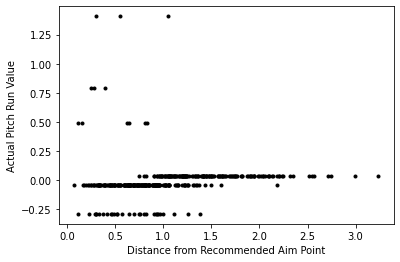

In [ ]:
#see how proximity to the recommended location when throwing the right pitch improved or harmed run value 
plt.plot(right_pitch.distance_from_recommended_aim_point.values, right_pitch.actual_run_value.values, 'k.')
plt.xlabel('Distance from Recommended Aim Point')
plt.ylabel('Actual Pitch Run Value')
plt.show()

In [ ]:
np.corrcoef(right_pitch.distance_from_recommended_aim_point.values, right_pitch.actual_run_value.values)[0,1]

0.07852433331731754

Further distance from aim point tended to mean a worse pitch (more positive run value), but it's weak correlation. You an see in that plot though, it looks like most of the outcomes are I guess probably a ball or a strike, and you can see once the diatance gets past 1 or 1.5, the run value takes a step up, moving from strikes to balls. Makes sense.

In [ ]:
pitcher_results = merged.groupby('pitcher', as_index = False).agg(n = ('actual_run_value', 'count'),
                                                                  correct_pitch_rate = ('pitcher_threw_right_pitch', 'mean'),
                                                                  average_actual_pitch_expected_run_value = ('pitch_utility', 'mean'),
                                                                  average_actual_run_value = ('actual_run_value', 'mean'))

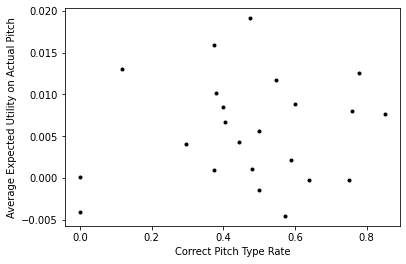

Correlation: 0.12215620581716709


In [ ]:
plt.plot(pitcher_results.correct_pitch_rate.values, pitcher_results.average_actual_pitch_expected_run_value.values, 'k.')
plt.xlabel('Correct Pitch Type Rate')
plt.ylabel('Average Expected Utility on Actual Pitch')
plt.show()
print('Correlation: ' + str(np.corrcoef(pitcher_results.correct_pitch_rate.values, pitcher_results.average_actual_pitch_expected_run_value.values)[0,1]))

Very weak positive correlation, which is the opposite of what we'd expect. We'd expect throwing the correct pitch more often would lead to lwoer run values. There's a potential weighting issue here though. Each of those points represent a pitcher, but they may have different numbers of plate appearances going into the calculations of the means.

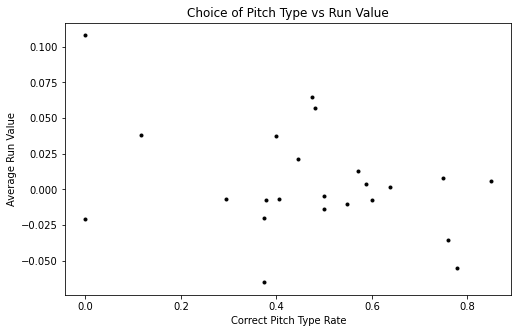

Correlation: -0.36768380847096427


In [ ]:
plt.figure(figsize = (8,5))
plt.plot(pitcher_results.correct_pitch_rate.values, pitcher_results.average_actual_run_value.values, 'k.')
plt.xlabel('Correct Pitch Type Rate')
plt.ylabel('Average Run Value')
plt.title('Choice of Pitch Type vs Run Value')
plt.show()
print('Correlation: ' + str(np.corrcoef(pitcher_results.correct_pitch_rate.values, pitcher_results.average_actual_run_value.values)[0,1]))

Pretty good correlation here. The more a pitcher threw the correct pitch type, the lower their actual run value. 

In [ ]:
pitcher_results2 = right_pitch.groupby('pitcher', as_index = False).agg(n = ('actual_run_value', 'count'),
                                                                  distance = ('distance_from_recommended_aim_point', 'mean'),
                                                                  average_actual_pitch_expected_run_value = ('pitch_utility', 'mean'),
                                                                  average_actual_run_value = ('actual_run_value', 'mean'))

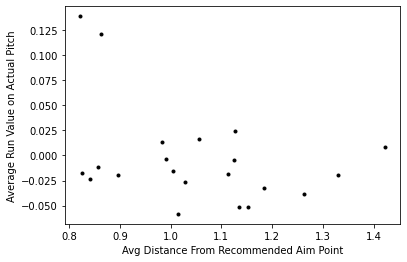

Correlation: -0.3686926721557728


In [ ]:
plt.plot(pitcher_results2.distance.values, pitcher_results2.average_actual_run_value.values, 'k.')
plt.xlabel('Avg Distance From Recommended Aim Point')
plt.ylabel('Average Run Value on Actual Pitch')
plt.show()
print('Correlation: ' + str(np.corrcoef(pitcher_results2.distance.values, pitcher_results2.average_actual_run_value.values)[0,1]))

As distance increases on average, the actual average run value decreases. That's a little backwards

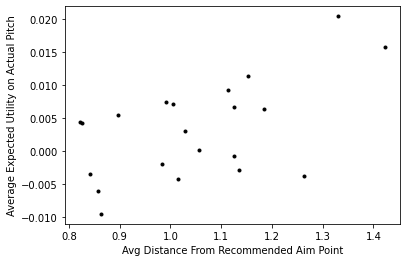

Correlation: 0.557518998577313


In [ ]:
plt.plot(pitcher_results2.distance.values, pitcher_results2.average_actual_pitch_expected_run_value.values, 'k.')
plt.xlabel('Avg Distance From Recommended Aim Point')
plt.ylabel('Average Expected Utility on Actual Pitch')
plt.show()
print('Correlation: ' + str(np.corrcoef(pitcher_results2.distance.values, pitcher_results2.average_actual_pitch_expected_run_value.values)[0,1]))

As distance increases, the expected utility of the actual pitch also increases, which is bad for pitchers, as we'd expect.

#### **Juan Soto and Jacob Degrom**

In [ ]:
#read in the skill estimates 
skill = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/pitcher_skill_estimates.csv')

skill.columns = ['pitcher', 'pitcher_name', 'avg', 'CH', 'CU', 'FC', 'FF', 'FS', 'KC', 'SI', 'SL']

#get the usages for each of these pitchers 
non_z_scored = all_data.copy()
non_z_scored[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']] = standardizer.inverse_transform(non_z_scored[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']].values)
pitch_usages = pd.DataFrame()
for pitcher in skill.pitcher.values:
  pdf = non_z_scored.loc[all_data.pitcher == pitcher]
  n = pdf.shape[0]
  usages = pdf.groupby('pitch_type', as_index = False).agg(N = ('is_swing', 'count'),
                                                           release_speed = ('release_speed', 'mean'),
                                                           mx = ('mx', 'mean'),
                                                           mz = ('mz', 'mean'),
                                                           release_spin_rate = ('release_spin_rate', 'mean'))
  usages.N = usages.N / n
  usages['pitcher_id'] = pitcher
  pitch_usages = pitch_usages.append(usages, ignore_index = True)

pitch_usages = pitch_usages.loc[pitch_usages.N >= 0.05]

#define a dictionary of execution score dictionaries for each pitcher 
execution_scores = dict()
for pitcher in skill.pitcher.values:
  pitches = pitch_usages.loc[pitch_usages.pitcher_id == pitcher]
  pitcher_skill = skill.loc[skill.pitcher == pitcher]
  pitch_dict = dict()
  for p in pitches.pitch_type.values:
    pitch_dict.update({p: pitcher_skill[[p]].values[0]})
  
  execution_scores.update({pitcher: pitch_dict})

In [ ]:
#get the at bat from pybaseball
game = pybaseball.statcast(start_dt = '2022-10-08', end_dt = '2022-10-08')
game = game.loc[game.inning == 1]
game = game[needed_columns]
game = organize_data(game)

This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


In [ ]:
pa = game.loc[(game.batter == 665742) & (game.pitcher == 594798)]
pa['batter_index'] = 26

#run the model on the pa
pa = pa[::-1]
pa['plate_x_ft'] = pa.plate_x 
pa['plate_z_ft'] = pa.plate_z 
pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']] = standardizer.transform(pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']].values)
#loop through the pitches
pred_outcomes = torch.empty((1,9)).to(device)
x_data = torch.tensor(pa[features].values.astype(float), dtype = torch.float).to(device)
y_data = torch.tensor(pa.outcome.values, dtype = torch.long).to(device)
h0 = model.init_hidden().to(device)
for p in range(pa.shape[0]):
  yhat, h1 = model(x_data[p].unsqueeze(0), h0, y_data[p].unsqueeze(0))
  pred_outcomes = torch.cat((pred_outcomes, yhat), dim = 0)
  h0 = h1 
  if p == pa.shape[0] - 2:
    #save the hidden state after the second to last pitch 
    h = h0 

#now softmax the predictions and append onto the bross pa 
ypreds = nn.functional.softmax(pred_outcomes[1:,:], dim = 1).detach().cpu().numpy()
pa[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = ypreds 

#and calculate the utilities for each of those pitches 
pa = get_utilities(pa)

pa[['player_name', 'batter', 'pitch_type', 'balls', 'strikes','plate_x', 'plate_z', 'plate_x_ft', 'plate_z_ft', 'outcome', 'o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'swing_utility', 'take_utility', 'pitch_utility', 'batter_optimal_decision_is_swing']]

,player_name,batter,pitch_type,balls,strikes,plate_x,plate_z,plate_x_ft,plate_z_ft,outcome,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility,pitch_utility,batter_optimal_decision_is_swing
1246,"deGrom, Jacob",665742,FF,0,0,-1.413476,-0.278155,-1.15,2.01,0,0.874183,8.639832e-02,0.012539,0.017497,0.006928,2.009149e-03,3.455413e-04,1.499176e-05,8.429145e-05,-0.048043,0.027074,0.027074,0
1227,"deGrom, Jacob",665742,FF,1,0,0.683923,0.499087,0.62,2.77,2,0.022283,4.735605e-01,0.106642,0.284687,0.078987,2.027349e-02,7.341691e-03,5.458377e-04,5.679510e-03,-0.043321,-0.044922,-0.043321,1
1181,"deGrom, Jacob",665742,FF,1,1,-0.797291,-0.073618,-0.63,2.21,2,0.005055,3.230076e-01,0.227680,0.312839,0.090848,2.623058e-02,7.959725e-03,6.946512e-04,5.686061e-03,-0.048200,-0.065197,-0.048200,1
1132,"deGrom, Jacob",665742,SL,1,2,2.117738,-2.681469,1.83,-0.34,0,0.964043,2.646323e-12,0.035911,0.000043,0.000002,3.607744e-07,2.156716e-09,3.390002e-12,1.880556e-11,-0.205746,0.046000,0.046000,0
1076,"deGrom, Jacob",665742,FF,2,2,-1.057985,0.488860,-0.85,2.76,2,0.124491,4.791221e-02,0.275140,0.373337,0.130319,3.433371e-02,8.563903e-03,7.123018e-04,5.191207e-03,-0.082924,0.000732,0.000732,0


The optimal batter decision on that pitch was to take it. That would've given an expected run value of 0.0007. Juan Soto decided to swing, which gave a much worse expected run value of -0.083. 

In [ ]:
igrid = initial_grid(26, 594798, h, bhand = 0., phand = 1., balls = 2, strikes = 2)

#get the execution score adjusted grid 
exe_grid = execution_score_adjusted_grid(igrid, execution_scores[594798])

In [ ]:
final_data = igrid.merge(exe_grid, how = 'inner', on = ['pitch_type', 'location_index'])

In [ ]:
expected_min = final_data.expected_pitcher_utility.min()
pitcher_optimal_decision = final_data.loc[final_data.expected_pitcher_utility == expected_min]

In [ ]:
pitcher_optimal_decision

,release_speed,plate_x,plate_z,mx,mz,bat_handR,pit_handR,balls,strikes,release_spin_rate,location_index,plate_x_ft,plate_z_ft,batter_index,pitcher_id,pitch_type,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility,actual_run_value,pitch_utility,batter_optimal_decision_is_swing,expected_pitcher_utility
275,0.432261,-0.125863,0.158143,-1.169485,-0.355596,0.0,1.0,2.0,2.0,-1.858151,2555,-0.06338,2.43662,26,594798,CH,0.000503,0.095364,0.213542,0.308873,0.269933,0.072263,0.0215,0.001746,0.016276,-0.044644,-0.250163,NaN,-0.044644,1,-0.018665


In [ ]:
#plot the actual pitch, the absolute best pitch, and the optimal equilibrium pitch 
plt.figure(figsize = (7,6))
plt.plot(-1*pa.plate_x_ft.values[-1], pa.plate_z_ft.values[-1], 'x', label = 'Actual Pitch: FF')
plt.plot(-1*pitcher_optimal_decision.plate_x_ft.values[0], pitcher_optimal_decision.plate_z_ft.values[0], 'x', label = 'Optimal Pitch: CH')
plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
plt.legend()
plt.xlabel("Horizontal Location (Pitcher's Perspective)")
plt.ylabel('Vertical Location')
plt.xlim(-1.5,1.5)
plt.ylim(1,4)
plt.title("deGrom vs Soto: Stackelberg Equilibrium")
plt.show()